In [18]:
import os
import sys
import numpy as np
import torch
import matplotlib.pyplot as plt
from torch.utils.data._utils.collate import default_collate

cwd = os.getcwd()
sys.path.append(os.path.dirname(os.path.dirname(cwd)))

In [19]:
from torch.utils.data import DataLoader
from src.utils import load_model
from src.problems import EVRP
# from src.graph.evrp_network import EVRPNetwork

In [77]:
# model, _ = load_model('../../outputs/evrp_4/rollout_20230614T160835') # with lots of batches and normal cost
model, _ = load_model('../../outputs/evrp_4/rollout_20230614T160732') # with cost and lots of batches
moder, _ = load_model('../../outputs/evrp_4/rollout_20230614T190949') # test!!
model.eval()  # Put in evaluation mode to not track gradients

  [*] Loading model from ../../outputs/evrp_4/rollout_20230614T160732/epoch-4.pt
  [*] Loading model from ../../outputs/evrp_4/rollout_20230614T190949/epoch-0.pt


AttentionEVRPModel(
  (init_embed_node): Linear(in_features=5, out_features=128, bias=True)
  (project_node_embeddings): Linear(in_features=128, out_features=384, bias=False)
  (project_fixed_context): Linear(in_features=128, out_features=128, bias=False)
  (encoder): GraphAttentionEncoder(
    (layers): Sequential(
      (0): MultiHeadAttentionLayer(
        (0): SkipConnection(
          (module): MultiHeadAttention()
        )
        (1): Normalization(
          (normalizer): BatchNorm1d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        )
        (2): SkipConnection(
          (module): Sequential(
            (0): Linear(in_features=128, out_features=512, bias=True)
            (1): ReLU()
            (2): Linear(in_features=512, out_features=128, bias=True)
          )
        )
        (3): Normalization(
          (normalizer): BatchNorm1d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        )
      )
      (1): MultiHeadAtten

In [78]:
env = EVRP
val_dataset = env.make_dataset(
        size=4,
        num_samples=3,
        num_trucks=2,
        num_trailers=3,
        truck_names=None,
    )

In [79]:
def collate_fn(batch):
    data_batch, graph_batch = zip(*batch)

    return default_collate(data_batch), list(graph_batch)


In [80]:
def tensor_to_tuples(tensor):
    batch_size, features, time = tensor.shape
    edges = []
    for b in range(batch_size):
        batch_list = tuple(tensor[b, :, time - 1].tolist())
        edges.append([batch_list])

    return edges

Finished Batches 1/3
graph_index 0


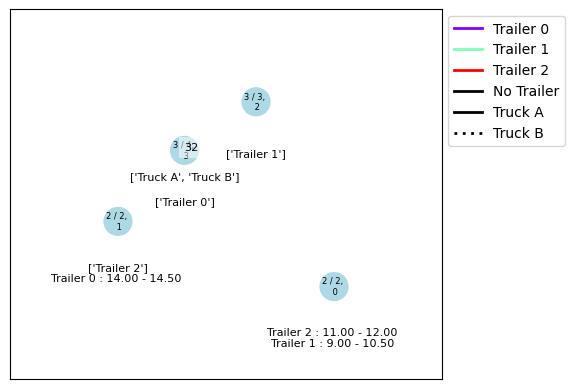

tensor([ 1.,  3.,  1., -1.,  0.])
0.24967949430201977


AssertionError: The truck is not in the source node, Truck B, None

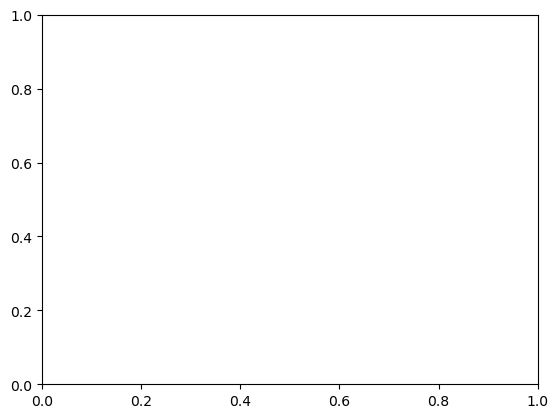

In [82]:
# Need a dataloader to batch instances
dataloader = DataLoader(val_dataset, batch_size=1000, collate_fn=collate_fn)

# Make var works for dicts
batch = next(iter(dataloader))

# Run the model
model.eval()
model.set_decode_type('greedy')

with torch.no_grad():
    length, _, edges = model(batch[0], batch[1], return_pi=True)

edges=edges.transpose(0, 1)
edges=edges.transpose(1, 2)
# for i, graph in enumerate(batch[1]):
graph = batch[1][0]
i = 0
print("graph_index", i)
fig, ax = plt.subplots()
graph.draw(ax=ax, with_labels=True)
plt.show()
for edge in edges[i]:
    print(edge)
    print(graph.euclid_distance(int(edge[0]), int(edge[1])))
    fig, ax = plt.subplots()

    graph.remove_edges()
    edge = graph.visit_edge([edge])
    graph.update_attributes(edge)
    graph.draw(ax=ax, with_labels=True)
    plt.show()

In [76]:
graph.euclid_distance(0, 2)

0.8431416407711573

In [ ]:
tensor_to_tuples()